In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
clean_df = pd.read_csv('AmesHousing.csv', sep='\t')
print(clean_df.head())

   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0       

In [8]:
print(clean_df.shape)

(2930, 82)


In [9]:
print(clean_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [10]:
# duplicates check
clean_df.duplicated().sum()

np.int64(0)

In [11]:
# check number of numerical vs cathegorical features
clean_df.dtypes.value_counts()
# => all treated as cathegorical, even though some should'nt

object     43
int64      28
float64    11
Name: count, dtype: int64

43 out of the 82 fetures are cathegorical, so for the next steps we will work on converting them to numerical

In [12]:
# check number of missing values per feature
missing = clean_df.isnull().sum().sort_values(ascending=False).head(30)
print(missing)


Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Mas Vnr Type      1775
Fireplace Qu      1422
Lot Frontage       490
Garage Qual        159
Garage Yr Blt      159
Garage Cond        159
Garage Finish      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Qual           80
Bsmt Cond           80
BsmtFin Type 1      80
Mas Vnr Area        23
Bsmt Full Bath       2
Bsmt Half Bath       2
Total Bsmt SF        1
BsmtFin SF 1         1
BsmtFin SF 2         1
Garage Area          1
Garage Cars          1
Bsmt Unf SF          1
Electrical           1
Lot Shape            0
Street               0
Lot Area             0
dtype: int64


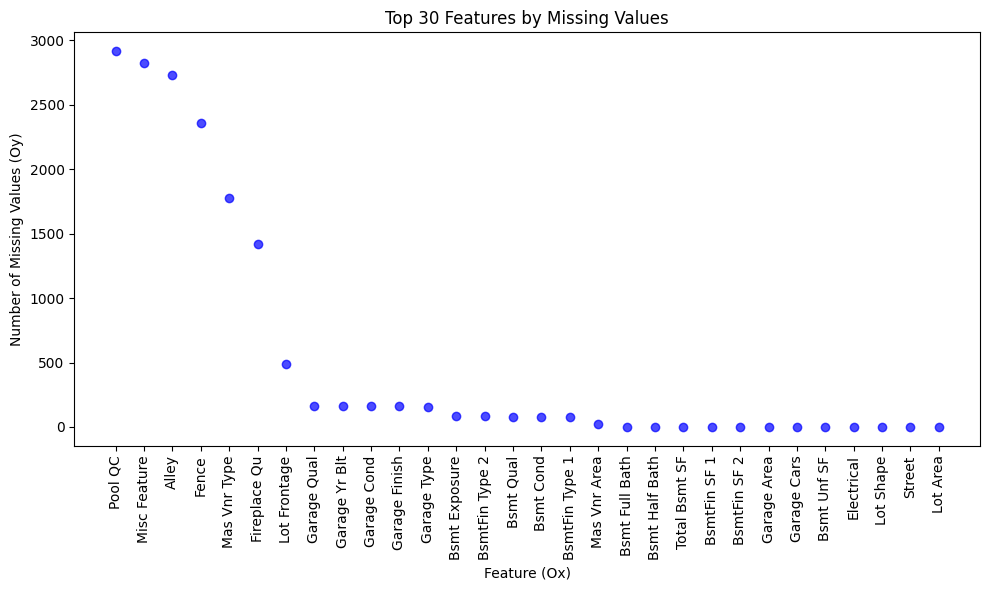

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(missing.index, missing.values, color='blue', alpha=0.7)

# Add labels and title
plt.xticks(rotation=90)
plt.xlabel("Feature (Ox)")
plt.ylabel("Number of Missing Values (Oy)")
plt.title("Top 30 Features by Missing Values")

# Make layout tidy and show plot
plt.tight_layout()
plt.show()

The plot shows the features that have a high amount of missing values.

In [33]:
pool_sizes = clean_df['Pool Area'].sort_values(ascending=False).head(13)
print(pool_sizes)

no_pool = (clean_df['Pool Area'] == 0).sum()
print(no_pool)
print("Percentage of houses without a pool: {:.2f}%".format((no_pool / len(clean_df)) * 100))

2498    800
2735    738
2357    648
1566    576
2278    561
1760    555
2350    519
2570    512
1498    480
2089    444
1940    368
2230    228
1063    144
Name: Pool Area, dtype: int64
2917
Percentage of houses without a pool: 99.56%


Based on the quant analysis we decided to drop the 2 columns regarding the pool, instead replaced them with hasPool: 0 if has not, 1 if has

In [15]:
df_noPool = clean_df.copy(deep=True)
df_noPool['hasPool'] = (clean_df['Pool Area'] > 0).astype(int)
df_noPool.drop(['Pool Area', 'Pool QC'], axis=1, inplace=True)
print(df_noPool['hasPool'].value_counts())

hasPool
0    2917
1      13
Name: count, dtype: int64


In [32]:
no_fireplace = (clean_df['Fireplaces'] == 0).sum()
print(no_fireplace)
print("Percentage of houses without a fireplace: {:.2f}%".format((no_fireplace / len(clean_df)) * 100))


1422
Percentage of houses without a fireplace: 48.53%


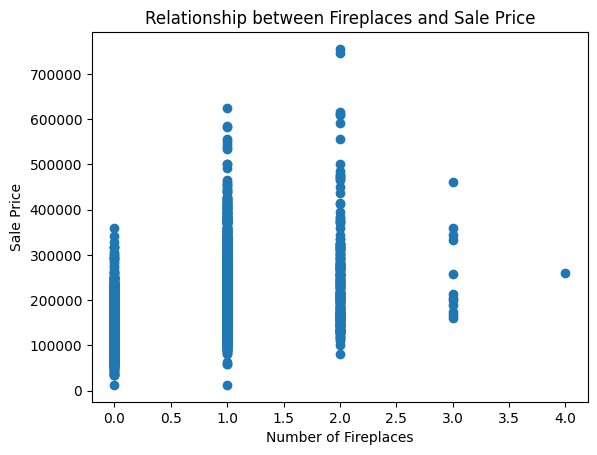

In [18]:
plt.scatter(clean_df['Fireplaces'], clean_df['SalePrice'])
plt.xlabel('Number of Fireplaces')
plt.ylabel('Sale Price')
plt.title('Relationship between Fireplaces and Sale Price')
plt.show()

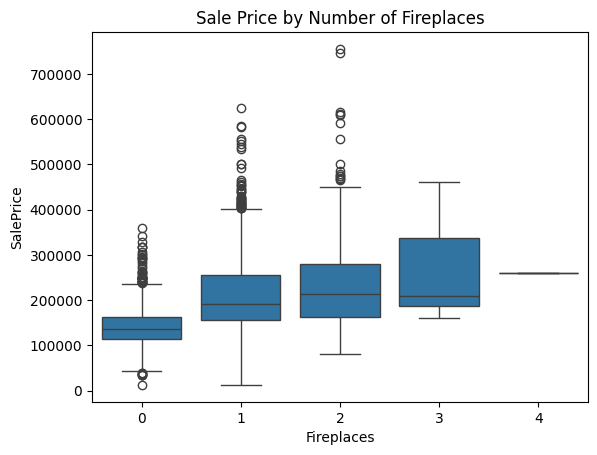

In [19]:
sns.boxplot(x='Fireplaces', y='SalePrice', data=clean_df)
plt.title('Sale Price by Number of Fireplaces')
plt.show()

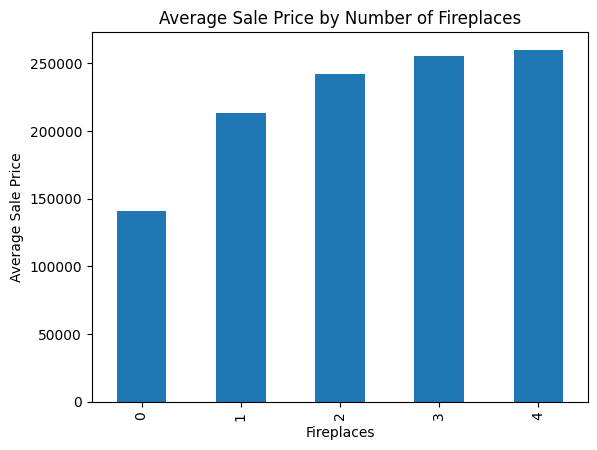

In [ ]:
"Bar plot of mean sale price per fireplace count"
clean_df.groupby('Fireplaces')['SalePrice'].mean().plot(kind='bar')
plt.ylabel('Average Sale Price')
plt.title('Average Sale Price by Number of Fireplaces')
plt.show()

Given by the above plots there seems to be a direct corelation between how many fireplaces a house has and its price, and the quant analysis shows that the fireplace column is populated plenty.

In [ ]:
print("Fireplace Quality value counts, for existing values:")
print(clean_df['Fireplace Qu'].value_counts())
print("Number of missing values in 'Fireplace Qu':")
print(clean_df['Fireplace Qu'].isna().sum())
print("Percentage of missing values in 'Fireplace Qu': {:.2f}%".format((clean_df['Fireplace Qu'].isna().sum() / len(clean_df)) * 100))

Fireplace Quality value counts, for existing values:
Fireplace Qu
Gd    744
TA    600
Fa     75
Po     46
Ex     43
Name: count, dtype: int64
Number of missing values in 'Fireplace Qu':
1422
Percentage of missing values in 'Fireplace Qu': 48.53%


This is the same percentage as the houses that have no fireplace, so we cant ignore this column based only on the non existing values, we need to test how the Qu column affects the price.